# TP 2: Résolution d'équations non linéaires
## PHY-3500: Physique numérique (H2021) - 26 février 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy as sym

## Le potentiel de Lennard-Jones

### Question 1

On cherche à exprimer les points de rebroussement en fonction de l'énergie $\epsilon_n$. On sait qu'il existe deux points de rebroussement, notés $r_-$ et $r_+$, et qu'ils correspondent aux positions où l'impulsion est nulle (positions où les noyaux changent de direction). L'impulsion linéaire local $p(r)$ est donnée par

$$ p(r)=\pm\left[2 \mu(E_n - V(r))\right]^{1 / 2}. $$

En utilisant les variables sans dimension suivantes

$$ \epsilon_n = \frac{E_n}{V_{0}} \quad, \quad x=\frac{r}{\sigma} \quad, \quad \gamma=\left(\frac{2 \mu \sigma^{2} V_{0}}{\hbar^{2}}\right)^{1 / 2}, $$

il est possible d'écrire l'impulsion linéaire local sous la forme

$$ p(x)=\pm\left[2 \mu V_0 (\epsilon_n - v(x))\right]^{1 / 2}, $$

où on a

$$ v(x)=4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right]. $$

Les points de rebroussement $x_-$ et $x_+$ sont donc déterminés par l'équation $ p(x) = 0 $, soit

$$
p(x) = \pm\left[2 \mu V_0 \left(\epsilon_n - 4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right]\right)\right]^{1 / 2} = 0, \\
\implies \epsilon_n = 4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right], \\
\implies \frac{\epsilon_n}{4}x^{12}  + x^6 - 1 = 0. \\
$$

En utilisant la substitution $y = x^6$, on a que

$$
\frac{\epsilon_n}{4}y^{2}  + y - 1 = 0,
$$

ce qui nous donne les solutions suivantes en utilisant la formule quadratique :

$$
y = \frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n} \quad \text{et} \\
y = -\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n},
$$

avec $\epsilon_n \neq 0$. Si $\epsilon_n = 0$, on a que $y = 1$, mais le cas $\epsilon_n = 0$ n'est pas intéressant puisqu'il signifie que l'énergie $E = 0$. En revenant à une solution avec $x$, on a que

$$
x_- = \left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \\
x_+ = \left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6}.
$$

Il est important de noter que l'on désire obtenir des solutions réelles et positives pour les valeurs de $x_-$ et $x_+$ et on ne considère donc pas les racines complexes. On doit s'assurer que notre choix de $x_-$ et $x_+$ fait en sorte que $x_+ > x_-$. Pour ce faire, on doit d'abord déterminer le domaine de la valeur de $\epsilon_n$, soit si $\epsilon_n$ est un nombre positif ou négatif dans notre problème. On remarque que le point de rebroussement $x_+$ est un nombre réel pour $\epsilon_n < 0$ et un nombre complexe pour $\epsilon_n > 0$. On se doute donc que $\epsilon_n$ doit être négatif. Comme confirmation, on peut observer la courbe du potentiel réalisée par le bloc de code suivant.

In [19]:
def get_dimensionless_potential(x):
    return 4*(x**-12 - x**-6)

def show_dimensionless_potential():
    x = np.linspace(0.93, 2, 1000)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line, = ax.plot(x, get_dimensionless_potential(x), color='k', lw=2)
    ax.set_title("Potentiel adimensionnel de Lennard-Jones", fontsize=14)

    ax.set_xlabel("Position adimensionnelle $x$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Potentiel adimensionnel $v(x)$ [-]", fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

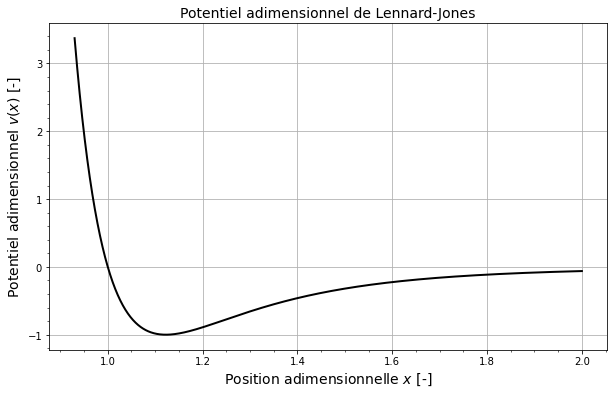

In [8]:
show_dimensionless_potential()

On remarque donc que le potentiel $v(x)$ est contraint de $[-1, 0[$ pour tout $x > 1$. Comme les points de rebroussement sont déterminés par l'équation $p(x) = 0$ donc $\epsilon_n = v(x)$, on a que 

$$ \epsilon_n \in [-1, 0[. $$

On doit maintenant s'assurer que notre choix de $x_-$ et $x_+$ fait en sorte que $x_+ > x_-$ sur ce domaine. Le bloc de code suivant permet d'observer les positions des points de rebroussement $x_-$ et $x_+$ obtenues en fonction du paramètre $\epsilon_n$.

In [3]:
def get_xmin(eps):
    return (2*((eps + 1)**(1/2) - 1)/eps)**(1/6)

def get_xmax(eps):
    return (-2*((eps + 1)**(1/2) + 1)/eps)**(1/6)

def show_turning_points():
    eps = np.linspace(-1, -0.01, 1000)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line1, = ax.plot(eps, get_xmin(eps), color='b', lw=2, label="Point de rebroussement $x_-$")
    line2, = ax.plot(eps, get_xmax(eps), color='r', lw=2, label="Point de rebroussement $x_+$")
    ax.set_title("Position adimensionnel des points de rebroussement en fonction de l'énergie", fontsize=14)

    ax.set_xlabel("Énergie adimensionnelle $\epsilon_n$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Position adimensionnel $x$ [-]", fontsize=14)
    ax.minorticks_on()
    ax.legend(fontsize=14)

    plt.grid()
    plt.show()
    plt.close(fig)

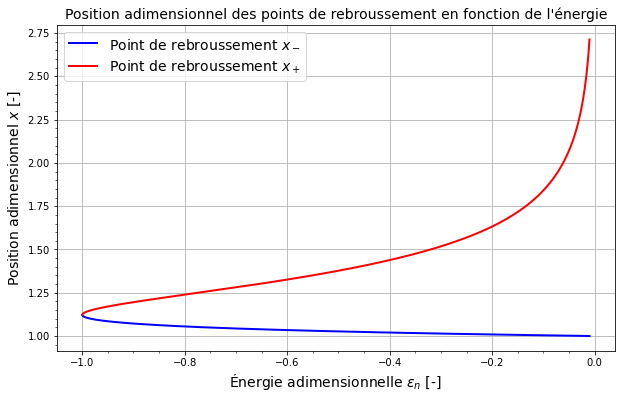

In [10]:
show_turning_points()

Notre choix de $x_-$ et $x_+$ fait bien en sorte que $x_+ > x_-$ sur le domaine de validité de $\epsilon_n$. La solution finale pour les points de rebroussement en fonction de $\epsilon_n$ est donc
$$
x_-(\epsilon_n) = \left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \quad x_+(\epsilon_n) = \left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6},
$$
ou plutôt
$$
r_-(\epsilon_n) = \sigma\left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \quad r_+(\epsilon_n) = \sigma\left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6}.
$$


### Question 2

In [68]:
def get_quasi_classical_action(eps, gamma, n):
    assert eps < 0 and eps > -1, r"Attention! Le domaine de validité de l'énergie adimensionnelle est [-1 < epsilon < 0]"
    
    x_min: float = get_xmin(eps)
    x_max: float = get_xmax(eps)
    
    integrand = lambda x, eps: (eps - get_dimensionless_potential(x))**(1/2)
    
    action: float = integrate.quad(func=integrand, a=x_min, b=x_max, args=(eps,))[0]
    
    return gamma*action - (n + 1/2)*np.pi



######################################
# Fonction de bissection
######################################





######################################
# Fonction de bissection
######################################

### Question 3

In [69]:
gamma_O2: float = 150
nb_state: float = 20
n_states: list = list(range(nb_state))

######################################
# Bissection
######################################
eps_1 = -0.99 
for n in n_states: 
    print(get_quasi_classical_action(eps=eps_1, gamma=gamma_O2, n=n))
    
######################################
# Bissection
######################################

-1.1286060295768108
-4.270198683166604
-7.411791336756397
-10.55338399034619
-13.694976643935982
-16.836569297525774
-19.97816195111557
-23.11975460470536
-26.261347258295157
-29.402939911884946
-32.544532565474746
-35.686125219064536
-38.82771787265433
-41.96931052624412
-45.11090317983392
-48.25249583342371
-51.394088487013505
-54.535681140603295
-57.67727379419309
-60.81886644778288


### Question 4

## Pandémie et relaxation

### Question 5

## Pandémie et relaxation accélérée

### Question 6

### Question 7

### Question 8

### Question 9